# Testing LOSD
### Bevölkerung, seit 1901

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Jahr, seit 1901.

https://data.integ.stadt-zuerich.ch/dataset/bev324od3243

Datum: 15.03.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3243_bev_bestand_jahr_od3243.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Setze einige Pfadvariabeln

**BITTE HIER ANPASSEN**

In [6]:
package_name = "bev324od3243"
package_name = package_name.upper()
print(package_name)

BEV324OD3243


In [7]:
dataset_name = "bev324od3243.csv"

**Statische Pfade CKAN-URLs**

In [8]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"
ld_integ_url ="https://ld.integ.stadt-zuerich.ch/statistics/view/"

In [9]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"
ld_prod_url ="https://ld.stadt-zuerich.ch/statistics/view/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [10]:
from IPython.display import Markdown as md

In [11]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name.lower()))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev324od3243 

In [12]:
md(" **2. Dataset auf INTEG-LD:** Link {} ".format(ld_integ_url+package_name.upper()))

 **2. Dataset auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3243 

In [13]:
md(" **3. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name.lower()))

 **3. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev324od3243 

In [14]:
md(" **4. Dataset auf PROD-LD:** Link {} ".format(ld_prod_url+package_name.upper()))

 **4. Dataset auf PROD-LD:** Link https://ld.stadt-zuerich.ch/statistics/view/BEV324OD3243 

### Setze ein paar Zeitvariabeln
Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe [Link](https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime)
Zuerst die Zeitvariabeln als Strings

In [15]:
now = datetime.date.today()
year_today = now.strftime("%Y")

Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [16]:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Importiere den Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [17]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [18]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            #fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp = ld_prod_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        #fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp = ld_integ_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3243/observation?format=csv


In [19]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['ZEIT_lang']
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested.sort_values("ZEIT_lang", ascending=True)

web


ZEIT_lang    datetime64[ns]
ZEIT_code            object
RAUM_lang            object
RAUM_code            object
BEW                 float64
dtype: object

In [20]:
data2betested.sort_values("ZEIT_lang", ascending=True).head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW
0,1921-12-31,Z31121921,Stadt Zürich (ab 1934),R30000,201242
1,1924-12-31,Z31121924,Stadt Zürich (ab 1934),R30000,206719


Berechne weitere Attribute falls notwendig

`ACHTUNG`!

In Pandas kann `datetime` Daten ab dem Jahr **1677** speichern. Das liegt daran, dass Pandas datetime64[ns] auf der Basis von NumPy verwendet, das wiederum den Datentyp datetime64 bereitstellt, der auf dem Standard des Proleptischen Gregorianischen Kalenders basiert. Dieser Kalender geht bis zum Jahr 1677 zurück.

Alternative: Abfangen des Problems mit Funktion:

-----------------------------------------------

In [21]:
def convert_to_datetime(date_str):
    try:
        date = pd.to_datetime(date_str)
        if date.year < 1677:
            raise ValueError("Datum liegt außerhalb des gültigen Bereichs für datetime-Objekte.")
        return date
    except ValueError:
        return pd.NaT  # Falls ein ungültiges Datum übergeben wurde, gib NaT (Not a Timestamp) zurück


-------------------------------------------------------

In [22]:
data2betested = (
    data2betested
    .copy()
    .assign(
        StichtagDatJahr = lambda x: x.ZEIT_lang.apply(convert_to_datetime),
        #StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_lang.astype(str),
        #Jahr = lambda x: x.ZEIT_lang.dt.year,
        Jahr_nbr = lambda x: x.ZEIT_code.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_code.str[1:].astype(int),

    )
    .sort_values('ZEIT_lang', ascending=False)
    )
data2betested.head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
1,1924-12-31,Z31121924,Stadt Zürich (ab 1934),R30000,206719,1924-12-31,1924-12-31,1924,30000
0,1921-12-31,Z31121921,Stadt Zürich (ab 1934),R30000,201242,1921-12-31,1921-12-31,1921,30000


Minimales und maximales Jahr im Datensatz

In [23]:
data_max_date = str(max(data2betested.StichtagDatJahr).year)
data_min_date = str(min(data2betested.StichtagDatJahr).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")

Die Daten haben ein Minimumjahr von 1921 und ein Maximumjahr von 1924


Zeitbereich aus den Daten:

In [24]:
data_max_date = str(max(data2betested.Jahr_nbr))

try:
    if min(data2betested.Jahr_nbr) < 1678:
        data_min_date="1688"
    else:
        data_min_date = str(min(data2betested.Jahr_nbr))
except ValueError:
    print("Fehler...")

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1921 und ein Maximumjahr von 1924


### Einfache Datentests

In [25]:
data2betested.head(2).T

,1,0
ZEIT_lang,1924-12-31 00:00:00,1921-12-31 00:00:00
ZEIT_code,Z31121924,Z31121921
RAUM_lang,Stadt Zürich (ab 1934),Stadt Zürich (ab 1934)
RAUM_code,R30000,R30000
BEW,206719,201242
StichtagDatJahr,1924-12-31 00:00:00,1921-12-31 00:00:00
StichtagDatJahr_str,1924-12-31,1921-12-31
Jahr_nbr,1924,1921
RAUM_my_sort,30000,30000


In [26]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 0
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_lang            2 non-null      datetime64[ns]
 1   ZEIT_code            2 non-null      object        
 2   RAUM_lang            2 non-null      object        
 3   RAUM_code            2 non-null      object        
 4   BEW                  2 non-null      float64       
 5   StichtagDatJahr      2 non-null      datetime64[ns]
 6   StichtagDatJahr_str  2 non-null      object        
 7   Jahr_nbr             2 non-null      int32         
 8   RAUM_my_sort         2 non-null      int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(4)
memory usage: 678.0 bytes


In [27]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 2 rows (observations) and 9 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [28]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [29]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [30]:
data2betested.index.year.unique()


Int64Index([1921, 1924], dtype='int64', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [31]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,StichtagDatJahr_str
count,2,2,2,2,2
unique,NaN,2,1,1,2
top,NaN,Z31121921,Stadt Zürich (ab 1934),R30000,1921-12-31
freq,NaN,1,2,2,1
mean,1923-07-02 00:00:00,NaN,NaN,NaN,NaN
min,1921-12-31 00:00:00,NaN,NaN,NaN,NaN
25%,1922-10-01 00:00:00,NaN,NaN,NaN,NaN
50%,1923-07-02 00:00:00,NaN,NaN,NaN,NaN
75%,1924-04-01 00:00:00,NaN,NaN,NaN,NaN
max,1924-12-31 00:00:00,NaN,NaN,NaN,NaN


Beschreibe numerische Attribute

In [32]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr_nbr,RAUM_my_sort
count,2,2,2
mean,"203,980","1,922","30,000"
std,"3,873",2,0
min,"201,242","1,921","30,000"
25%,"202,611","1,922","30,000"
50%,"203,980","1,922","30,000"
75%,"205,350","1,923","30,000"
max,"206,719","1,924","30,000"


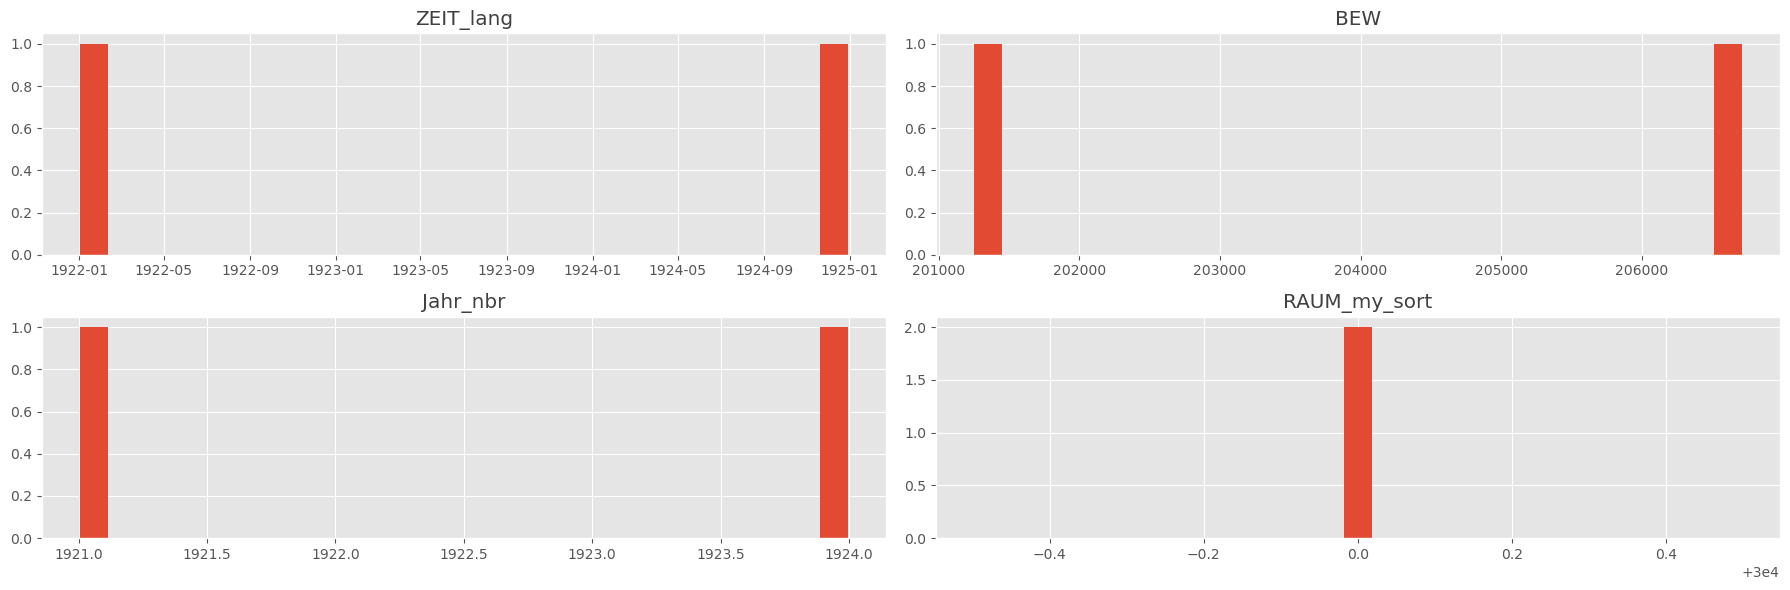

In [33]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [34]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,


### Nullwerte und Missings?

In [35]:
data2betested.isnull().sum()

ZEIT_lang              0
ZEIT_code              0
RAUM_lang              0
RAUM_code              0
BEW                    0
StichtagDatJahr_str    0
Jahr_nbr               0
RAUM_my_sort           0
dtype: int64

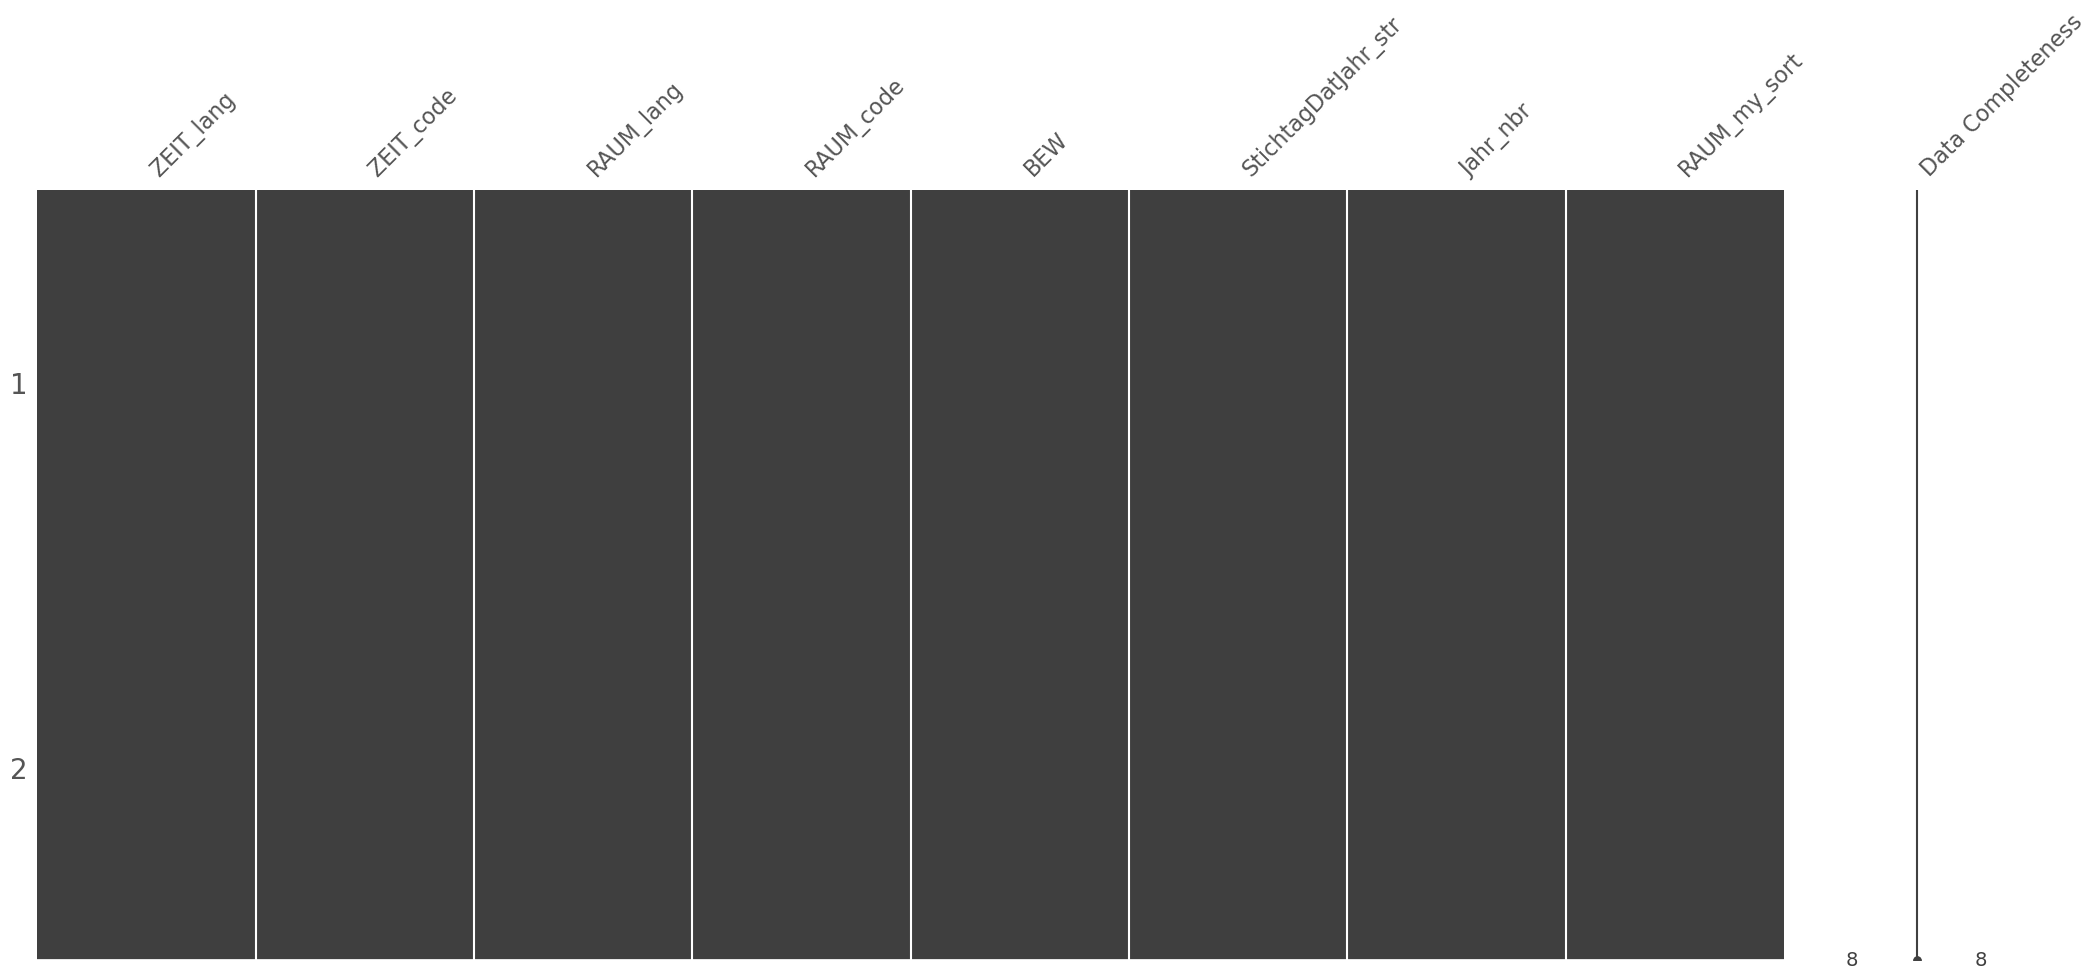

In [36]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [37]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr_nbr,sum_AnzBestWir
0,1924,206719
1,1921,201242


In [38]:
data2betested.RAUM_lang.unique()

array(['Stadt Zürich (ab 1934)'], dtype=object)

In [39]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','RAUM_lang', 'RAUM_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values(['Jahr_nbr','RAUM_code'], ascending=[False, True]) 
agg_Quarts.reset_index().head(50)

,Jahr_nbr,RAUM_lang,RAUM_code,sum_AnzBestWir
0,1924,Stadt Zürich (ab 1934),R30000,206719
1,1921,Stadt Zürich (ab 1934),R30000,201242


In [40]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [41]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,
1924-12-31,1924-12-31,Z31121924,Stadt Zürich (ab 1934),R30000,206719,1924-12-31,1924,30000


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [42]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [43]:
myAggAll = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAggAll.reset_index().head(30)

,StichtagDatJahr,sum_WBev
0,1924-12-31,206719
1,1921-12-31,201242


In [44]:
myTitle="Bevölkerungsentwicklung, seit "+data_min_date

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_WBev'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggAll.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('QuarLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [45]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [46]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr','Jahr_nbr', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr_nbr,RAUM_lang,RAUM_code,sum_WBev
0,1921-12-31,1921,Stadt Zürich (ab 1934),R30000,201242
1,1924-12-31,1924,Stadt Zürich (ab 1934),R30000,206719


In [47]:
#help(sns.catplot)     

In [48]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

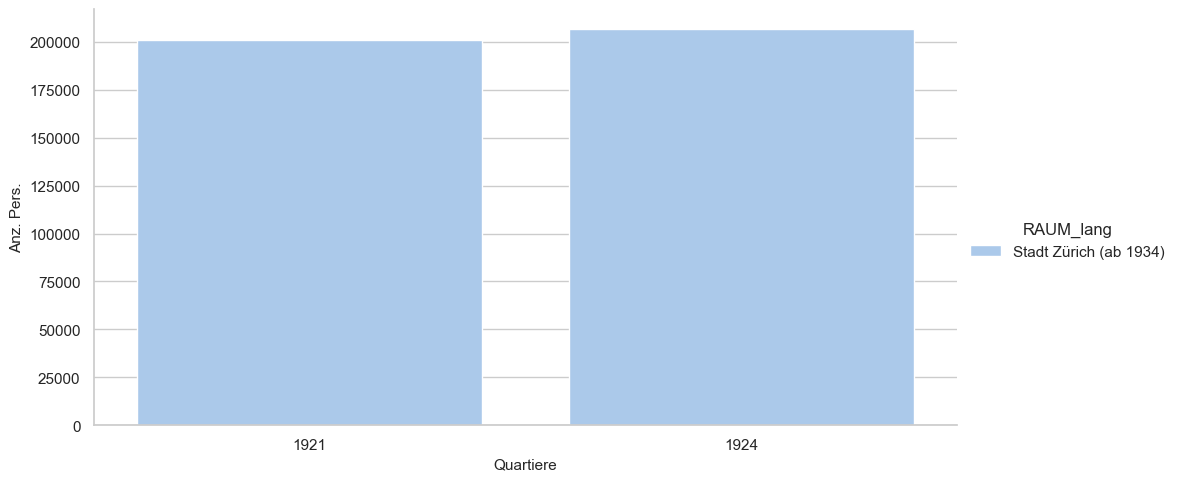

In [49]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_nbr"
            , y="sum_WBev"
            , hue="RAUM_lang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_code", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [50]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [51]:
myAggBar = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myAggBar

,,,,,sum_WBev
Jahr_nbr,StichtagDatJahr_str,RAUM_lang,RAUM_code,RAUM_my_sort,
1921,1921-12-31,Stadt Zürich (ab 1934),R30000,30000,201242
1924,1924-12-31,Stadt Zürich (ab 1934),R30000,30000,206719


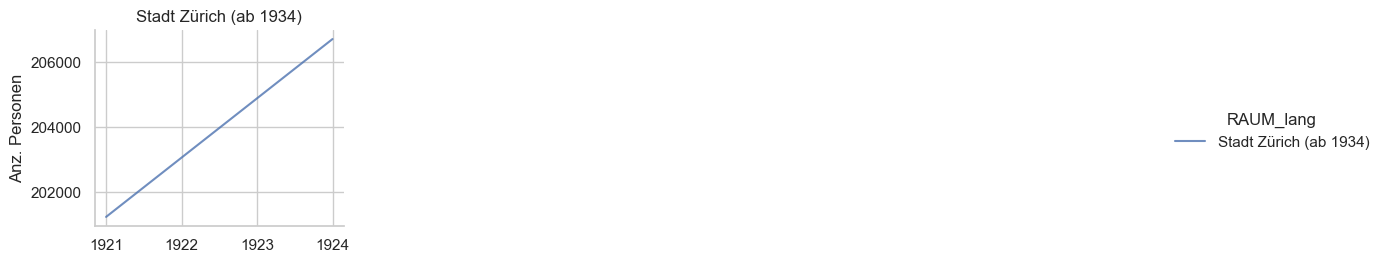

In [52]:
g2 = sns.FacetGrid(myAggBar.reset_index(), col="RAUM_lang", hue="RAUM_lang", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr_nbr","sum_WBev",alpha=.8)

g2.set_axis_labels("","Anz. Personen")
g2.set_titles(col_template="{col_name}", row_template="{row_name}")

g2.add_legend()


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)